# Autoregression Model

In [1]:
import pickle
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Loading Data File

In [2]:
path = "Data/"
building = "avenal-animal-shelter"
interval = 5 # min


with open(path + building + "_training_data.pkl", 'r') as f:
    training_data = pickle.load(f)

with open(path + building + "_test_data.pkl", "r") as f:
    test_data = pickle.load(f)
    

# Features in Dataset

In [3]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53187 entries, 2018-04-18 23:16:42+00:00 to 2018-10-25 23:13:42+00:00
Data columns (total 9 columns):
action                                        53187 non-null float64
action_duration                               53187 non-null object
dt                                            53187 non-null float64
previous_action                               42307 non-null float64
t_next                                        53187 non-null float64
t_in                                          53187 non-null float64
t_out                                         53186 non-null float64
occ                                           53186 non-null float64
zone_temperatureHVAC_Zone_Shelter_Corridor    53186 non-null float64
dtypes: float64(8), object(1)
memory usage: 4.1+ MB


# Preprocessing Data

Action features has values 0,1,2,3,4,5 which is transformed to values:
0 - no action
1 - heating
2 - cooling

Select the rows in datasets such that interval time is constant (5 minutes)

In [4]:
def fix_data(data, interval):
    """Fixes up the data. Makes sure we count two stage as single stage actions, don't count float actions,
    converts action duration and dt to floats, fill's nan's in action_duration and drops all datapoints which
    don't have dt equal to interval.
    :param data:
    :param interval: float:minutes"""
    def f(x):
        if x == 0:
            return 0
        elif x == 2 or x == 5:
            return 2
        elif x ==1 or x == 3:
            return 1

    data["action"] = data["action"].map(f)
    


    return data, data[data["dt"] == interval]

# get preproccessed test and training data
org_training_data, training_data = fix_data(training_data, interval)
org_test_data, test_data = fix_data(test_data, interval)

print(training_data.head())
print(test_data.head())

                           action action_duration   dt  previous_action  \
time                                                                      
2018-04-18 23:16:42+00:00       0          300.0s  5.0              NaN   
2018-04-18 23:21:42+00:00       0          600.0s  5.0              NaN   
2018-04-18 23:26:42+00:00       0          900.0s  5.0              NaN   
2018-04-18 23:31:42+00:00       0         1200.0s  5.0              NaN   
2018-04-18 23:36:42+00:00       0         1500.0s  5.0              NaN   

                           t_next       t_in      t_out  occ  \
time                                                           
2018-04-18 23:16:42+00:00    69.5  69.483333  66.499700  0.0   
2018-04-18 23:21:42+00:00    69.5  69.500000  66.499700  0.0   
2018-04-18 23:26:42+00:00    69.5  69.500000  66.520546  0.0   
2018-04-18 23:31:42+00:00    69.4  69.500000  66.583083  0.0   
2018-04-18 23:36:42+00:00    69.5  69.400000  66.666466  0.0   

                         

# Dropping Features

In [5]:
def filter_data(data):
    data = data.drop(['dt', 'previous_action', 'action_duration', 'zone_temperatureHVAC_Zone_Shelter_Corridor'], axis=1)
        
    return data

training_data = filter_data(training_data)
test_data = filter_data(test_data)

print(training_data.head())
print(test_data.head())

                           action  t_next       t_in      t_out  occ
time                                                                
2018-04-18 23:16:42+00:00       0    69.5  69.483333  66.499700  0.0
2018-04-18 23:21:42+00:00       0    69.5  69.500000  66.499700  0.0
2018-04-18 23:26:42+00:00       0    69.5  69.500000  66.520546  0.0
2018-04-18 23:31:42+00:00       0    69.4  69.500000  66.583083  0.0
2018-04-18 23:36:42+00:00       0    69.5  69.400000  66.666466  0.0
                           action  t_next  t_in      t_out  occ
time                                                           
2018-03-20 00:00:00+00:00       0    72.8  72.8  67.778613  0.0
2018-03-20 00:05:00+00:00       0    73.0  72.8  67.807436  0.0
2018-03-20 00:10:00+00:00       0    73.0  73.0  67.835998  0.0
2018-03-20 00:15:00+00:00       0    73.0  73.0  67.864038  0.0
2018-03-20 00:20:00+00:00       0    73.0  73.0  67.891817  0.0


# Separating Target features 

In [6]:
def getTarget(data, target):
    y = data[target]
    return y

train_y = getTarget(training_data, 't_next')
train_y.head()

time
2018-04-18 23:16:42+00:00    69.5
2018-04-18 23:21:42+00:00    69.5
2018-04-18 23:26:42+00:00    69.5
2018-04-18 23:31:42+00:00    69.4
2018-04-18 23:36:42+00:00    69.5
Name: t_next, dtype: float64

In [7]:
def getFeatures(data, target):
    X = data.drop([target], axis=1)
    return X

train_X = getFeatures(training_data, 't_next')
train_X.head()

,action,t_in,t_out,occ
time,,,,
2018-04-18 23:16:42+00:00,0,69.483333,66.499700,0.0
2018-04-18 23:21:42+00:00,0,69.500000,66.499700,0.0
2018-04-18 23:26:42+00:00,0,69.500000,66.520546,0.0
2018-04-18 23:31:42+00:00,0,69.500000,66.583083,0.0
2018-04-18 23:36:42+00:00,0,69.400000,66.666466,0.0


In [8]:
test_y = getTarget(test_data, 't_next')
test_y.head()

time
2018-03-20 00:00:00+00:00    72.8
2018-03-20 00:05:00+00:00    73.0
2018-03-20 00:10:00+00:00    73.0
2018-03-20 00:15:00+00:00    73.0
2018-03-20 00:20:00+00:00    73.0
Name: t_next, dtype: float64

In [9]:
test_X = getFeatures(test_data, 't_next')
test_X.head()

,action,t_in,t_out,occ
time,,,,
2018-03-20 00:00:00+00:00,0,72.8,67.778613,0.0
2018-03-20 00:05:00+00:00,0,72.8,67.807436,0.0
2018-03-20 00:10:00+00:00,0,73.0,67.835998,0.0
2018-03-20 00:15:00+00:00,0,73.0,67.864038,0.0
2018-03-20 00:20:00+00:00,0,73.0,67.891817,0.0


# Linear Regression Model

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time 

linearModel = LinearRegression().fit(train_X, train_y)
test_pred = linearModel.predict(test_X)
test_pred


array([72.78454078, 72.78462129, 72.98311663, ..., 72.34433873,
       72.34440688, 72.44361466])

In [11]:
linearModel.coef_

array([-0.05392648,  0.99207781,  0.00279322,  0.04991643])

In [12]:
linearModel.intercept_

0.37195616448792634

# Equation obtained from Linear Regression Model

In [14]:
def singlePrediction(linearModel, test):
    pred = linearModel.intercept_ + linearModel.coef_[0]*test['action'] + linearModel.coef_[1]*test['t_in'] +\
            linearModel.coef_[2]*test['t_out'] + linearModel.coef_[3]*test['occ']
    return pred

# AutoRegression

At time t1, Temperature is predicted for 5 minute interval (t1+5) using the linear model . This predicted temperature is set as indoor temperature (t_in) to predict the temperature in the next 5 minute interval (t1+5+5). This process is repeated until the predicted temperature is for next one hour(t1+60).

Model is evaluated using Root mean squared error. To get true predictions at successive times, the test dataset(test_y) is shifted to n number of 5 minute intervals. 

In [15]:
import pandas as pd

def autoRegression(linearModel, test_X, time):
    next_pred5 = []
    n = time/5
    
    for index, row in test_X.iterrows():
        for i in range(1,n+1):
            t_next5 = singlePrediction(linearModel, row)
            row['t_in'] = t_next5            
        next_pred5.append(t_next5)
        
    test_pred = pd.DataFrame(next_pred5, index=test_X.index)
    next_test_y = test_y.shift(1-n,axis=0)
    nan_index = next_test_y.index[next_test_y.apply(np.isnan)]
    next_test_y = next_test_y.dropna()
    test_pred = test_pred.drop(nan_index) 
    rmse = mean_squared_error(next_test_y, test_pred)
    #print "time=", time, "rmse=", rmse
    return rmse
    


In [16]:
time = []
rmse = []
for i in range(5,65,5):
    rmse_i = autoRegression(linearModel, test_X, i)
    rmse.append(rmse_i)
    time.append(i)
    
result = pd.DataFrame(rmse, index=time)
result
    

,0
5,0.022051
10,0.064622
15,0.108191
20,0.154385
25,0.206573
30,0.263621
35,0.323388
40,0.385533
45,0.448942
50,0.515927


# Plot time vs rmse

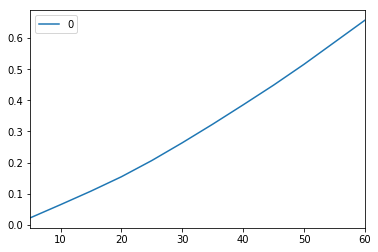

In [17]:
result.plot()